# **Training Notebook for Santander Dataset with AutoML**

## **1. Required Libraries & Setup**

In [1]:
# General Data Manipulation Libraries
import numpy as np; print('Numpy Version:', np.__version__)
import pandas as pd; print('Pandas Version:', pd.__version__)

# Model & Helper Libraries
from sklearn.model_selection import train_test_split

Numpy Version: 1.19.5
Pandas Version: 1.2.4


## **2. Results with Different Classifier models**

In [2]:
# Load Data
input_dir = '/kaggle/input/santander-customer-transaction-prediction/'
df_train = pd.read_csv(input_dir + 'train.csv')

# Train-Validation Split
var_colums = [c for c in df_train.columns if c not in ['ID_code','target']]
X = df_train.loc[:, var_colums]
y = df_train.loc[:, 'target']

# We are performing a 80-20 split for Training and Validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=11)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((160000, 200), (40000, 200), (160000,), (40000,))

### **2.1 Using LightGBM**

In [3]:
# Import LightGBM 
import lightgbm as lgb

In [4]:
# Create Dataset for LightGBM
lgb_train = lgb.Dataset(X_train.values, label=y_train.values)
lgb_eval = lgb.Dataset(X_valid.values, y_valid.values, reference=lgb_train)

In [5]:
clf = lgb.LGBMClassifier()
params = {    'boosting_type': 'gbdt',
              'objective': 'binary',
              'num_leaves': 40,
              'learning_rate': 0.05,
              'feature_fraction': 0.5,
              'metric': 'auc',  
              'bagging_fraction': 0.5,
              'is_unbalance': 'true',
              'n_estimators': 200
              }
clf.set_params(**params)
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_leaves': 40,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'feature_fraction': 0.5,
 'metric': 'auc',
 'bagging_fraction': 0.5,
 'is_unbalance': 'true'}

In [6]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train,eval_set=[(X_valid.values, y_valid.values)], eval_metric='auc', early_stopping_rounds=5, verbose=True)

[1]	valid_0's auc: 0.667921	valid_0's binary_logloss: 0.320279
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.687035	valid_0's binary_logloss: 0.317173
[3]	valid_0's auc: 0.705302	valid_0's binary_logloss: 0.314334
[4]	valid_0's auc: 0.717217	valid_0's binary_logloss: 0.311672
[5]	valid_0's auc: 0.728351	valid_0's binary_logloss: 0.309246
[6]	valid_0's auc: 0.738685	valid_0's binary_logloss: 0.307043
[7]	valid_0's auc: 0.745037	valid_0's binary_logloss: 0.304969
[8]	valid_0's auc: 0.750991	valid_0's binary_logloss: 0.303169
[9]	valid_0's auc: 0.757134	valid_0's binary_logloss: 0.301371
[10]	valid_0's auc: 0.762586	valid_0's binary_logloss: 0.299611
[11]	valid_0's auc: 0.768533	valid_0's binary_logloss: 0.29782
[12]	valid_0's auc: 0.774081	valid_0's binary_logloss: 0.29618
[13]	valid_0's auc: 0.777353	valid_0's binary_logloss: 0.294702
[14]	valid_0's auc: 0.779715	valid_0's binary_logloss: 0.293318
[15]	valid_0's auc: 0.782975	valid_0's binary_logloss: 

LGBMClassifier()

In [7]:
# Predictions
y_pred=clf.predict(X_valid)
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([39561,   439]))

**View Accuracy**

In [8]:
# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_valid)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_valid, y_pred)))

LightGBM Model accuracy score: 0.9082


**Classification Metrics**

In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     36015
           1       0.86      0.09      0.17      3985

    accuracy                           0.91     40000
   macro avg       0.88      0.55      0.56     40000
weighted avg       0.90      0.91      0.87     40000



**Confusion-matrix**

<AxesSubplot:>

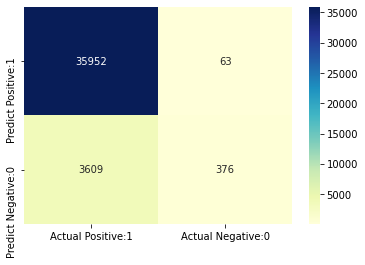

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_valid, y_pred)

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

### **6.1 Using AutoML H20**

In [11]:
# Install Dependencies
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

In [12]:
# Install and import h2o
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
import h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [13]:
from h2o.automl import H2OAutoML
h2o.init(max_mem_size='16G')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpr4dk02zp
  JVM stdout: /tmp/tmpr4dk02zp/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpr4dk02zp/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,2 months and 28 days
H2O_cluster_name:,H2O_from_python_unknownUser_18x52y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [14]:
df_h2o = h2o.import_file('/kaggle/input/santander-customer-transaction-prediction/train.csv')
type(df_h2o)

Parse progress: |█████████████████████████████████████████████████████████| 100%


h2o.frame.H2OFrame

In [15]:
# For binary classification, response should be a factor
df_h2o["target"] = df_h2o["target"].asfactor()

# Settign up Response and Predictor Columns
y_col = "target"
x_col = df_h2o.columns
x_col.remove(y_col) 
x_col.remove("ID_code")

In [16]:
aml = H2OAutoML(max_models=20, max_runtime_secs=3600, seed=11, verbosity="info", balance_classes = True) #max_runtime_secs
aml.train(x=x_col,y=y_col, training_frame=df_h2o)  

    
# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))  # Print all rows instead of default (10 rows)  

AutoML progress: |
08:03:50.486: Project: AutoML_20210817_80350481
08:03:50.499: Setting stopping tolerance adaptively based on the training frame: 0.00223606797749979
08:03:50.499: Build control seed: 11
08:03:50.501: training frame: Frame key: automl_training_py_1_sid_be85    cols: 202    rows: 200000  chunks: 16    size: 148759168  checksum: -5721889187161943030
08:03:50.502: validation frame: NULL
08:03:50.502: leaderboard frame: NULL
08:03:50.502: blending frame: NULL
08:03:50.502: response column: target
08:03:50.502: fold column: null
08:03:50.503: weights column: null
08:03:50.536: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
08:03:50.555: AutoML job created: 2021.08.17 08:03:50.481
08:03:50.556: AutoML build started: 2021.08.17 08:03:50.556
08:03

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20210817_080350,0.876061,0.22012,0.552021,0.250571,0.250977,0.0629894
StackedEnsemble_BestOfFamily_AutoML_20210817_080350,0.87274,0.2231,0.539924,0.257699,0.252855,0.0639357
GLM_1_AutoML_20210817_080350,0.859696,0.316467,0.50607,0.26647,0.297613,0.0885737
DeepLearning_grid__2_AutoML_20210817_080350_model_1,0.846638,0.244062,0.470743,0.264379,0.263758,0.0695681
DeepLearning_1_AutoML_20210817_080350,0.8463,0.243718,0.480706,0.284047,0.261932,0.0686082
XGBoost_grid__1_AutoML_20210817_080350_model_1,0.844073,0.24406,0.467902,0.288011,0.264251,0.0698284
DeepLearning_grid__3_AutoML_20210817_080350_model_1,0.843659,0.26191,0.468328,0.279272,0.275947,0.0761466
DeepLearning_grid__1_AutoML_20210817_080350_model_1,0.841493,0.269029,0.482134,0.284549,0.274062,0.0751098
GBM_grid__1_AutoML_20210817_080350_model_1,0.802942,0.289493,0.381699,0.313159,0.288919,0.0834744
XGBoost_3_AutoML_20210817_080350,0.748415,0.298982,0.297501,0.337446,0.289118,0.0835895


In [17]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

/opt/conda/lib/python3.7/site-packages/h2o/estimators/stackedensemble.py:836: H2ODeprecationWarning: The usage of stacked_ensemble.metalearner()['name'] will be deprecated. Metalearner now returns the metalearner object. If you need to get the 'name' please use stacked_ensemble.metalearner().model_id
  H2ODeprecationWarning


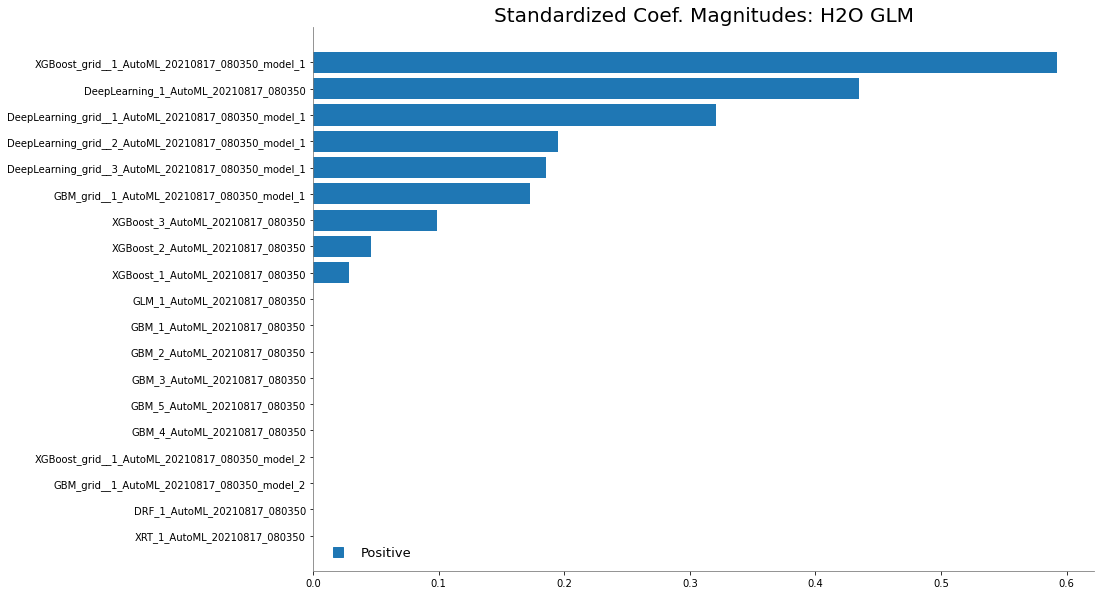

In [18]:
metalearner.std_coef_plot()